In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import random



In [ ]:
class replay_buffer():
    def __init__(self):
        self.memory = []
        
    def add(self, state, action, reward, next_state, done, goal):
        self.memory += [(state, action, reward, next_state, done, goal)]
        
    def clear(self):
        self.memory = []

In [ ]:
class DQNAgent():
    def __init__(self, state_size, action_size, goal_size, ddqn_flag, clip_target_value=True):
        self.state_size = state_size
        self.goal_size = goal_size
        self.action_size = action_size
        self.ddqn_flag = ddqn_flag
        self.clip_target_value = clip_target_value
        self.memory = []
        self.epsilon = 0.2
        self.epsilon_min = 0.02 
        self.epsilon_decay = 0.95
        self.tau = 0.95 
        self.gamma = 0.98
        self.batch_size = 128
        self.learning_rate = 1e-3
        self.buffer_size = int(1e6)
        self._set_model()
        
    def _set_model(self):
        tf.reset_default_graph()
        self.sess = tf.Session()
        
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')
        self.tfs_ = tf.placeholder(tf.float32, [None, self.state_size], 'next_state')
        self.tfg = tf.placeholder(tf.float32, [None, self.goal_size], 'goal')
        self.tfa = tf.placeholder(tf.int32, [None, ], 'action')
        self.tfr = tf.placeholder(tf.float32, [None, ], 'reward')
        self.tfd = tf.placeholder(tf.float32, [None, ], 'done')
        
        def _build_qnet(state, scope, trainable, reuse):
            with tf.variable_scope(scope, reuse=reuse):
                net = tf.layers.dense(tf.concat([state, self.tfg], axis=1), 256, activation=tf.nn.relu, trainable=trainable)
                q = tf.layers.dense(net, self.action_size, trainable=trainable)
            return q, tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
        
        self.q_eval, e_params = _build_qnet(self.tfs, 'eval', trainable=True, reuse=False)
        self.q_targ, t_params = _build_qnet(self.tfs_, 'target', trainable=False, reuse=False)
        
        self.update_op = [tf.assign(t, self.tau*e+(1-self.tau)*t) for t, e in zip(t_params, e_params)]

        #Q-Target = r + γQ(s’,argmax(Q(s’,a,ϴ),ϴ’))
        if self.ddqn_flag:
            q_eval_next, param = _build_qnet(self.tfs_, 'eval', trainable=True, reuse=True)
            q_eval_next_best_action = tf.argmax(q_eval_next, 1)
            self.q_target_value = tf.reduce_sum(self.q_targ * tf.one_hot(q_eval_next_best_action, self.action_size), axis=1)
        else:
            self.q_target_value = tf.reduce_max(self.q_targ, axis=1)
            
        self.q_target_value = self.tfr + self.gamma * (1-self.tfd) * self.q_target_value
       
        if self.clip_target_value:
            self.q_target_value = tf.clip_by_value(self.q_target_value, -1/(1-self.gamma), 0)
        
        self.q_eval_action_value = tf.reduce_sum(self.q_eval * tf.one_hot(self.tfa, self.action_size), axis=1)
        
        self.loss = tf.losses.mean_squared_error(self.q_target_value, self.q_eval_action_value)
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        self.saver = tf.train.Saver()
        
        self.sess.run(tf.global_variables_initializer())
        
    def choose_action(self, state, goal):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        act_values = self.sess.run(self.q_eval, {self.tfs: state, self.tfg: goal})
        return np.argmax(act_values[0])
    
    def remember(self, ep_experience):
        self.memory += ep_experience.memory
        if len(self.memory) > self.buffer_size:
              self.memory = self.memory[-self.buffer_size:] 
        
    def replay(self, optimization_steps):
        if len(self.memory) < self.batch_size: 
            return 0
        
        losses = 0
        for x in range(optimization_steps):
            minibatch = np.vstack(random.sample(self.memory, self.batch_size))
            ss = np.vstack(minibatch[:,0])
            acs = minibatch[:,1]
            rs = minibatch[:,2]
            nss = np.vstack(minibatch[:,3])
            ds = minibatch[:,4]
            gs = np.vstack(minibatch[:,5])
            
            loss, x = self.sess.run([self.loss, self.train_op], 
                     {self.tfs: ss, self.tfg: gs, self.tfa: acs,
                      self.tfr: rs, self.tfs_: nss, self.tfd: ds})
      
            losses += loss
            
        return losses/optimization_steps
    
    def update_target_net(self, decay=True):
        self.sess.run(self.update_op)
        if decay:
            self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)

In [ ]:

class BitFlip():
    def __init__(self, n, reward_type):
        self.n = n 
        self.reward_type = reward_type
    def reset(self):
        self.goal = np.random.randint(2, size=(self.n))
        self.state = np.random.randint(2, size=(self.n)) 
        return np.copy(self.state), np.copy(self.goal)
    def step(self, action):
        self.state[action] = 1-self.state[action] 
        done = np.array_equal(self.state, self.goal)
        if self.reward_type == 'sparse':
            reward = 0 if done else -1
 
        return np.copy(self.state), reward, done
    def render(self):
        print("\rstate :", np.array_str(self.state), end=' '*10)

In [ ]:
state_size = 30
action_size=30
goal_size=30

flag = True
env = BitFlip(state_size, 'sparse')
agent = DQNAgent(state_size, action_size, goal_size,ddqn_flag = flag)

In [ ]:
use_her = True 
num_epochs = 250
num_episodes = 16
optimization_steps = 40
K = 4 
losses = []
success_rate = []

ep_experience = replay_buffer()
ep_experience_her = replay_buffer()

start = time.clock()
for i in range(num_epochs):
    successes = 0
    for n in range(num_episodes):
        state, goal = env.reset()
        for t in range(state_size):
            action = agent.choose_action([state], [goal])
            next_state, reward, done = env.step(action)
            ep_experience.add(state, action, reward, next_state, done, goal)
            state = next_state
            if done:
                break
        successes += done

        if use_her: 
            for t in range(len(ep_experience.memory)):
                for k in range(K):
                    future = np.random.randint(t, len(ep_experience.memory))
                    goal = ep_experience.memory[future][3] 
                    state = ep_experience.memory[t][0]
                    action = ep_experience.memory[t][1]
                    next_state = ep_experience.memory[t][3]
                    done = np.array_equal(next_state, goal)
                    reward = 0 if done else -1
                    ep_experience_her.add(state, action, reward, next_state, done, goal)

        agent.remember(ep_experience)
        agent.remember(ep_experience_her)
        ep_experience.clear()
        ep_experience_her.clear()

    mean_loss = agent.replay(optimization_steps)
    
    agent.update_target_net()
    
    losses.append(mean_loss)
    success_rate.append(successes/num_episodes)
    print("\repoch", i+1, 'loss %.2f'%losses[-1], 'exploration %.2f'%agent.epsilon, end=' '*10)

print("Training time : %.2f"%(time.clock()-start), "s")

epoch 250 loss 0.04 exploration 0.02          Training time : 363.16 s


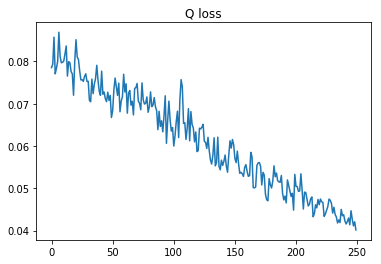

In [ ]:
plt.title('Q loss')
plt.plot(losses)
plt.show()

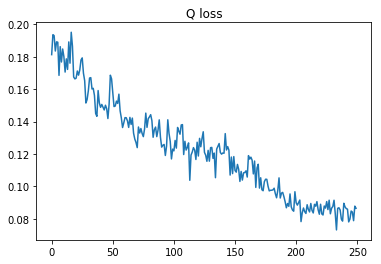

In [ ]:
plt.title('Q loss')
plt.plot(losses)
plt.show()


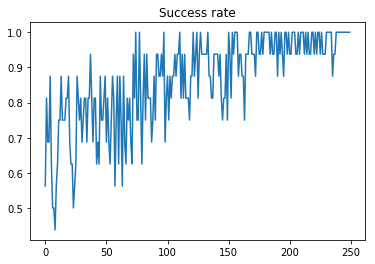

In [ ]:
plt.title('Success rate')
plt.plot(success_rate)
plt.show()


In [ ]:
for i in range(5):
    state, goal = env.reset()
    print("goal  :", np.array_str(goal))
    for t in range(state_size):
        action = agent.choose_action([state], [goal])
        next_state, reward, done = env.step(action)
        state = next_state
        env.render()
        time.sleep(0.6)
        if done:
            break
    print("Success :", done)

goal  : [0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0]
state : [0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0]          Success : False
goal  : [1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0]
state : [1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0]          Success : False
goal  : [1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0]
state : [0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1]          Success : False
goal  : [0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1]
state : [0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1]          Success : False
goal  : [0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1]
state : [1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0]          Success : False
